In [1]:
from __future__ import division
import ROOT
import root_numpy as rnpy
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM

Welcome to ROOTaaS 6.06/08


Using Theano backend.


In [7]:
def prepare_training_data(jet_list, label):
    # extract the tracks and put them in pt-order, hardest tracks first
    jet_tracks = [cur[-1] for cur in jet_list]
    jet_tracks = [sorted(cur, key = lambda tracks: tracks[0], reverse = True) for cur in jet_tracks]
    
    # zero-pad the track dimension, to make sure all jets fed into the network during training have the same length
    max_tracks = max([len(cur) for cur in jet_tracks])
    min_tracks = min([len(cur) for cur in jet_tracks])
    padded = [np.vstack([cur, np.full((max_tracks - len(cur), 8), 0, float)]) for cur in jet_tracks]
    
    batch_size = len(padded)
    timestep_size = max_tracks
    jet_dim = 8
    x_train = np.array(padded).reshape(batch_size, timestep_size, jet_dim)
    y_train = np.full((batch_size, 1), 1, float) # all are b-jets!
    
    return x_train, y_train, batch_size

In [3]:
# load back the keras model
model = load_model('./RNNtest.h5')

In [4]:
# load a batch of validation data
batch_size_jets = 12000
batch_size_tracks = 52000
read_pos_jets = 0
read_pos_tracks = 0
number_chunks = 0
chunks_limit = 1

In [5]:
while number_chunks < chunks_limit:
    number_chunks += 1
    
    # read in new chunk of jet and track data
    d1 = pd.DataFrame(rnpy.root2array("/mnt/t3nfs01/data01/shome/jpata/btv/gc/TagVarExtractor/GCa08e5e237323/TT_TuneCUETP8M1_13TeV-powheg-pythia8/job_0_out.root",
                                 treename = "tagVars/ttree", start = read_pos_jets, stop = read_pos_jets + batch_size_jets))
    d2 = pd.DataFrame(rnpy.root2array("/mnt/t3nfs01/data01/shome/jpata/btv/gc/TagVarExtractor/GCa08e5e237323/TT_TuneCUETP8M1_13TeV-powheg-pythia8/job_0_out.root",
                                 treename = "tagVars/ttree_track", start = read_pos_tracks, stop = read_pos_tracks + batch_size_tracks))
    
    # figure out where the next chunk should start so that we don't count any jets multiple times
    last_tracks = (int)(d2.tail(1)['Track_jetIndex'].iloc[0]-1)
    last_jet = (int)(d1.tail(1)['Jet_jetIndex'].iloc[0]-1)
    
    # find the latest jet index thatis fully contained in this chunk
    while(len(d2.loc[d2['Track_jetIndex'] == last_tracks]) == 0):
        last_tracks -= 1
        
    if last_tracks > last_jet:
        print("Error: have more tracks than jets! Choose different chunk sizes!")
        
    read_pos_jets += (d1.loc[d1['Jet_jetIndex'] == last_tracks].index[-1] + 1)
    read_pos_tracks += (d2.loc[d2['Track_jetIndex'] == last_tracks].index[-1] + 1)

    # add the track data to the jet list
    d1['track_data'] = pd.np.empty((len(d1.index),0)).tolist()
    
    # iterate over the track list to join jets with the tracks belonging to them
    for irow, row in d2.iterrows():
        # these are the track data of the current track:
        tracks = row[["Track_pt", "Track_eta", "Track_phi", "Track_dxy", "Track_dz", "Track_IP", "Track_IP2D", "Track_length"]].as_matrix()
        jet_index = int(row["Track_jetIndex"])
        if jet_index > last_tracks:
            break
        table_index = d1.loc[d1['Jet_jetIndex'] == jet_index].index[0]

        # append the tracks data to the matching jet in the main table
        d1['track_data'][table_index].append(tracks)
    
    # now divide the jets and put them in separate lists, according to their flavour
    jets_b = []
    jets_l = []
    jets_c = []

    # iterate over the jet list, with already matched tracks
    for irow, row in d1.iterrows():
        jet_index = int(row["Jet_jetIndex"])
        if jet_index > last_tracks:
            break

        flavour = int(row["Jet_flavour"])

        # select the right list this jet belongs to
        if abs(flavour) == 5:
            jets = jets_b
        elif abs(flavour) == 4:
            jets = jets_c
        else:
            jets = jets_l

        # add the new jet to the list, if it contains tracks
        if len(row["track_data"]) > 0:
            jets += [(row["Jet_pt"], row["Jet_eta"], row["Jet_phi"], row["Jet_mass"], flavour, row["track_data"])]
        
    # now, have sorted jets in three lists, can use them directly for training!

/swshare/anaconda/lib/python2.7/site-packages/root_numpy/_tree.py:209: RuntimeWarning: ignoring duplicate branch named 'Track_nHitPixel'
  warn_missing_tree)


In [8]:
x_validation_b, _, batch_size_b = prepare_training_data(jets_b, 1)
x_validation_c, _, batch_size_c = prepare_training_data(jets_c, 0)
x_validation_l, _, batch_size_l = prepare_training_data(jets_l, 0)

In [9]:
# get the model's response and sort it into b and non-b
response_b = model.predict(x_validation_b, batch_size = batch_size_b)
response_c = model.predict(x_validation_c, batch_size = batch_size_c)
response_l = model.predict(x_validation_l, batch_size = batch_size_l)
response_nb = np.vstack([response_c, response_l])

In [10]:
# produce the ROC plot and save it so that it can be combined with the others
efficiency = np.array([])
misid_prob = np.array([])

# find the optimal threshold values for the plotting
minval = np.min(np.concatenate([response_nb, response_b]))
maxval = np.max(np.concatenate([response_nb, response_b]))
for threshold in np.arange(minval, maxval, (maxval - minval) / 1000):
    correct_b = (response_b >= threshold).sum()
    misid_b = (response_nb >= threshold).sum()
    
    if(correct_b > 1 and misid_b > 1):
        efficiency = np.append(efficiency, correct_b / len(response_b))
        misid_prob = np.append(misid_prob, misid_b / len(response_nb))

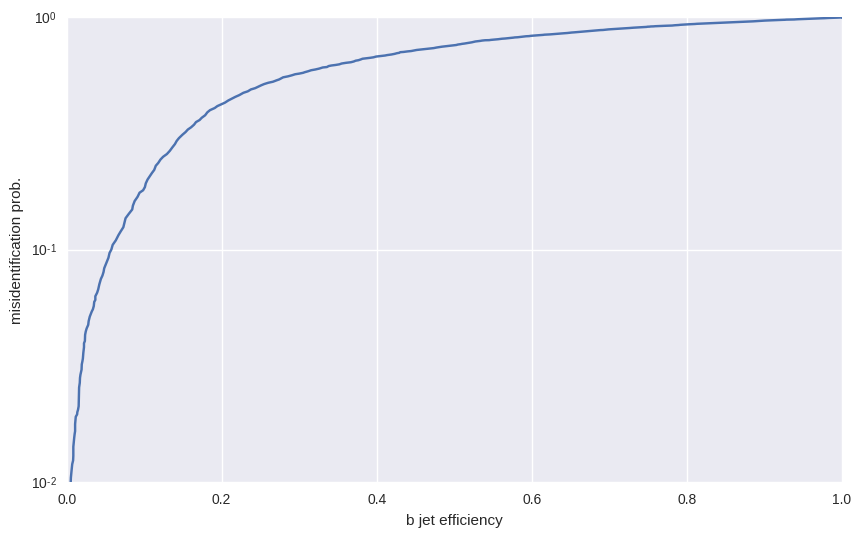

In [11]:
fig = plt.figure(figsize=(10,6))
plt.plot(efficiency, misid_prob)
plt.yscale('log')
axes = plt.gca()
axes.set_ylim([1e-2,1])
plt.xlabel('b jet efficiency')
plt.ylabel('misidentification prob.')
plt.show()

In [12]:
# can now plot the curve and save the values to a file
plotdata = np.vstack([misid_prob, efficiency])
np.save('./RNN_ROC', plotdata)